In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv, VecMonitor
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
from stochastic_proc.midprice import BrownianMidprice
from stochastic_proc.arrivals import PoissonArrivals, HawkesArrivals
from stochastic_proc.dynamics import LimitOrderDynamics
from envs.trading import TradingEnv
from agents.BaseAgent import AvellanedaStoikovAgent
from agents.GLFT import GLFTAgent
from rewards.RewardFunctions import PnLReward, InventoryQuadraticPenalty, SpreadRegularizer, SumReward
from utils.plot_single import run_and_log, plot_single_episode
from utils.plot_batch import simulate_batch, plot_batch
from utils.plot_lite import plot_trajectory, generate_results_table_and_hist, compare_poisson_vs_hawkes
from utils.calibration import hawkes_params
from utils.calibration import hawkes_params, glft_half_spreads
from envs.SB3tradingenv import SB3TradingVecEnv

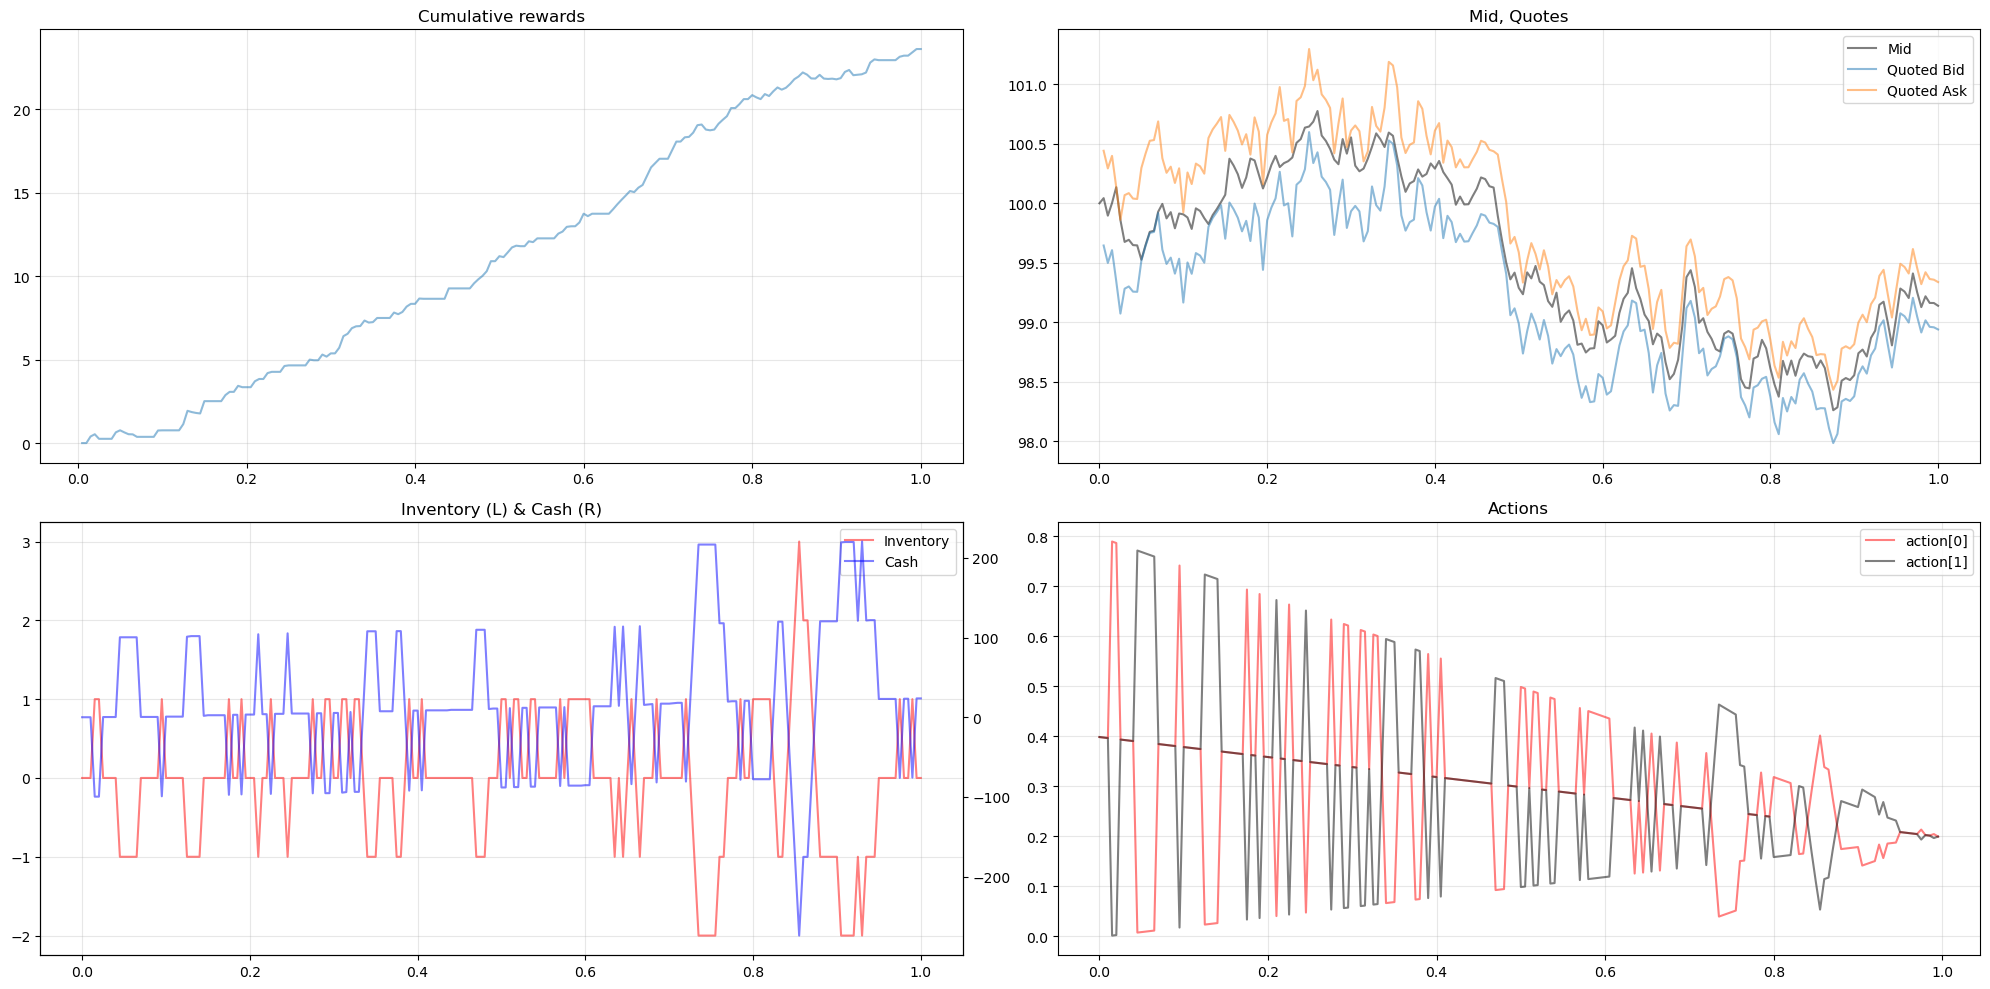

          Mean spread   Mean PnL   Std PnL Mean terminal inventory  \
Inventory    0.597927  23.744003  2.749834               -0.019531   

          Std terminal inventory  
Inventory               2.144126  


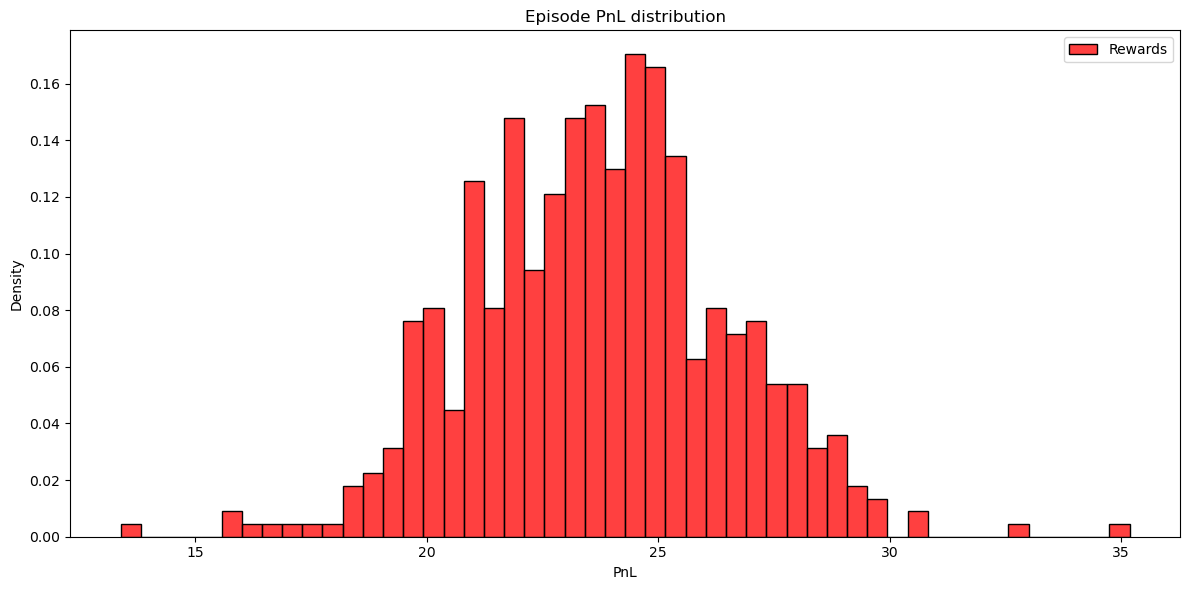

In [7]:
SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 100.0, 2.0, 140, 5, 1
dt = T / M
mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)

# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = AvellanedaStoikovAgent(env, gamma=0.1)
plot_trajectory(env, agent, show_reservation=False)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=512, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
agent = AvellanedaStoikovAgent(env_vec, gamma=0.1)
results, fig, totals = generate_results_table_and_hist(env_vec, agent)
print(results)

In [ ]:
SEED = 42
T, M = 1.0, 200
s0, sigma = 100.0, 2.0
A, k_fill = 140.0, 1.5
max_depth = 20.0
dt = T / M

K_TRAIN = 16  # number of parallel envs (8..32 is common)
K_EVAL  = 4

os.makedirs("./ckpt_best", exist_ok=True)
os.makedirs("./ckpt", exist_ok=True)
os.makedirs("./tb_mm", exist_ok=True)

In [ ]:
def make_env(seed_off=0):
    def _thunk():
        mid = BrownianMidprice(s0, sigma, num_traj=1, dt=dt, T=T, seed=SEED + seed_off)
        arr = PoissonArrivals(A, A, num_traj=1, dt=dt, T=T, seed=SEED + seed_off)
        dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=max_depth)

        env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED + seed_off, return_vectorized=False)
        return env
    return _thunk

In [ ]:
# train
vec_train = DummyVecEnv([make_env(i) for i in range(K_TRAIN)])
vec_train = VecMonitor(vec_train)                                  
vec_train = VecNormalize(vec_train, norm_obs=True, norm_reward=False, clip_obs=10.0)

# eval
vec_eval = DummyVecEnv([make_env(10_000 + i) for i in range(K_EVAL)])
vec_eval = VecMonitor(vec_eval)                                    
vec_eval = VecNormalize(vec_eval, norm_obs=True, norm_reward=False, clip_obs=10.0)
vec_eval.obs_rms = vec_train.obs_rms

PPO policy

In [ ]:
model = PPO(
    "MlpPolicy",
    vec_train,
    n_steps=M,                               
    batch_size=min(4096, K_TRAIN * M),       
    learning_rate=3e-4,
    n_epochs=10,
    gamma=1.0,                              
    gae_lambda=0.95,
    clip_range=0.2,
    vf_coef=0.5,
    ent_coef=0.0,
    seed=SEED,
    policy_kwargs=dict(net_arch=[128, 128]),
    tensorboard_log="./tb_mm/",
    device="auto",
)

eval_cb = EvalCallback(
    vec_eval,
    best_model_save_path="./ckpt_best/",
    log_path="./eval_logs/",
    eval_freq=(10_000 // M) * M,
    n_eval_episodes=5,
    deterministic=True,
)
ckpt_cb = CheckpointCallback(save_freq=50_000, save_path="./ckpt/", name_prefix="ppo_mm")

total_timesteps = 1_000_000
model.learn(total_timesteps=total_timesteps, callback=[eval_cb, ckpt_cb])


In [ ]:
seed_plot = 123

vec_plot = DummyVecEnv([make_env(seed_plot)])
vec_plot = VecMonitor(vec_plot)
vec_plot = VecNormalize(vec_plot, norm_obs=True, norm_reward=False, clip_obs=10.0)
vec_plot.obs_rms = vec_train.obs_rms

raw_env = make_env(seed_plot)()
obs_norm = vec_plot.reset()     # (1, obs_dim)
obs_raw, _ = raw_env.reset(seed=seed_plot)

In [ ]:
# assuming obs layout: [price, inventory, time_idx, cash]
ASSET_PRICE, INVENTORY, TIMEIDX, CASH = 0, 1, 2, 3

S_pre, S_post = [], []
Q, C, T_idx = [], [], []
HB, HA = [], []
R = []

done = False
while not done:
    
    action, _ = model.predict(obs_norm, deterministic=True)

    
    obs_norm, r_vec, dones_vec, infos = vec_plot.step(action)
    done = bool(dones_vec[0])

    
    next_obs_raw, r_raw, term_raw, trunc_raw, info_raw = raw_env.step(action[0])

    
    S_pre.append(obs_raw[ASSET_PRICE])
    Q.append(obs_raw[INVENTORY])
    T_idx.append(obs_raw[TIMEIDX])
    C.append(obs_raw[CASH])
    HB.append(action[0, 0])
    HA.append(action[0, 1])
    R.append(float(r_raw))
    S_post.append(next_obs_raw[ASSET_PRICE])

    obs_raw = next_obs_raw  

S_pre  = np.asarray(S_pre)           
S_post = np.asarray(S_post)               
Q      = np.asarray(Q)
C      = np.asarray(C)
T_idx  = np.asarray(T_idx)
HB     = np.asarray(HB)
HA     = np.asarray(HA)
R      = np.asarray(R)

timestamps = T_idx * (T / M)
cum_R = np.cumsum(R)
bid_quoted = S_post - HB
ask_quoted = S_post + HA

print(f"Episode PnL: {cum_R[-1]:.3f}")


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 10))
ax3b = ax3.twinx()

# (1) Cumulative PnL
ax1.plot(timestamps, cum_R, lw=1.8)
ax1.set_title("Cumulative Reward (PnL)")
ax1.set_xlabel("time"); ax1.set_ylabel("PnL"); ax1.grid(alpha=0.3)

# (2) Mid & Quotes
ax2.plot(timestamps, S_pre, color="k", lw=1.5, label="Mid Price")
ax2.plot(timestamps, bid_quoted, color="tab:blue",  alpha=0.9, label="Bid Price")
ax2.plot(timestamps, ask_quoted, color="tab:orange", alpha=0.9, label="Ask Price")
ax2.set_title("Mid & PPO Quotes")
ax2.set_xlabel("time"); ax2.set_ylabel("price")
ax2.grid(alpha=0.3); ax2.legend(loc="best")

# (3) Inventory & Cash
ax3.plot(timestamps, Q, color="tab:red",   label="Inventory")
ax3b.plot(timestamps, C, color="tab:green", label="Cash")
ax3.set_title("Inventory & Cash")
ax3.set_xlabel("time"); ax3.set_ylabel("inventory"); ax3b.set_ylabel("cash")
ax3.grid(alpha=0.3)
h1,l1 = ax3.get_legend_handles_labels()
h2,l2 = ax3b.get_legend_handles_labels()
ax3.legend(h1+h2, l1+l2, loc="best")

# (4) Actions (half-spreads)
ax4.plot(timestamps, HB, label="Bid half-spread")
ax4.plot(timestamps, HA, label="Ask half-spread")
ax4.set_title("PPO Actions"); ax4.set_xlabel("time"); ax4.set_ylabel("half-spread")
ax4.legend(loc="best"); ax4.grid(alpha=0.3)

plt.tight_layout(); plt.show()

Infinite horizon

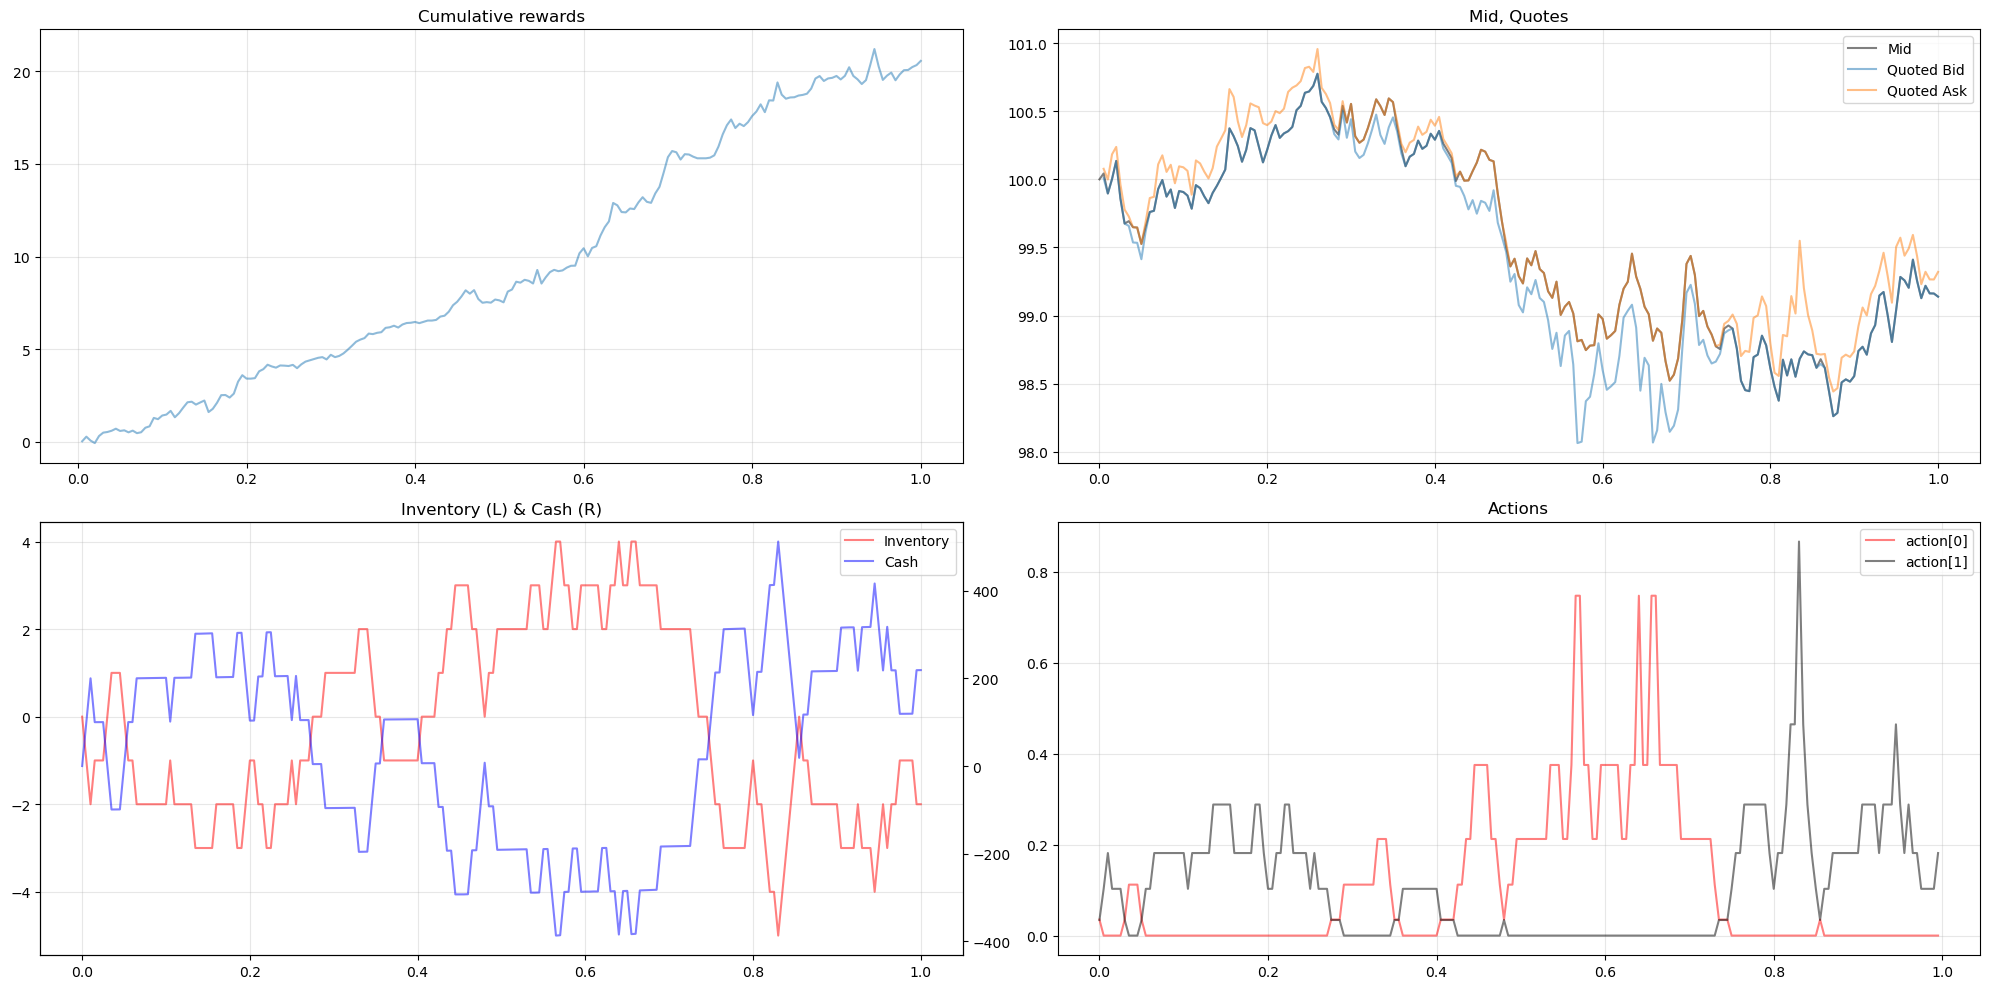

          Mean spread   Mean PnL   Std PnL Mean terminal inventory  \
Inventory    0.451653  26.018549  6.362134               -0.427734   

          Std terminal inventory  
Inventory               2.293556  


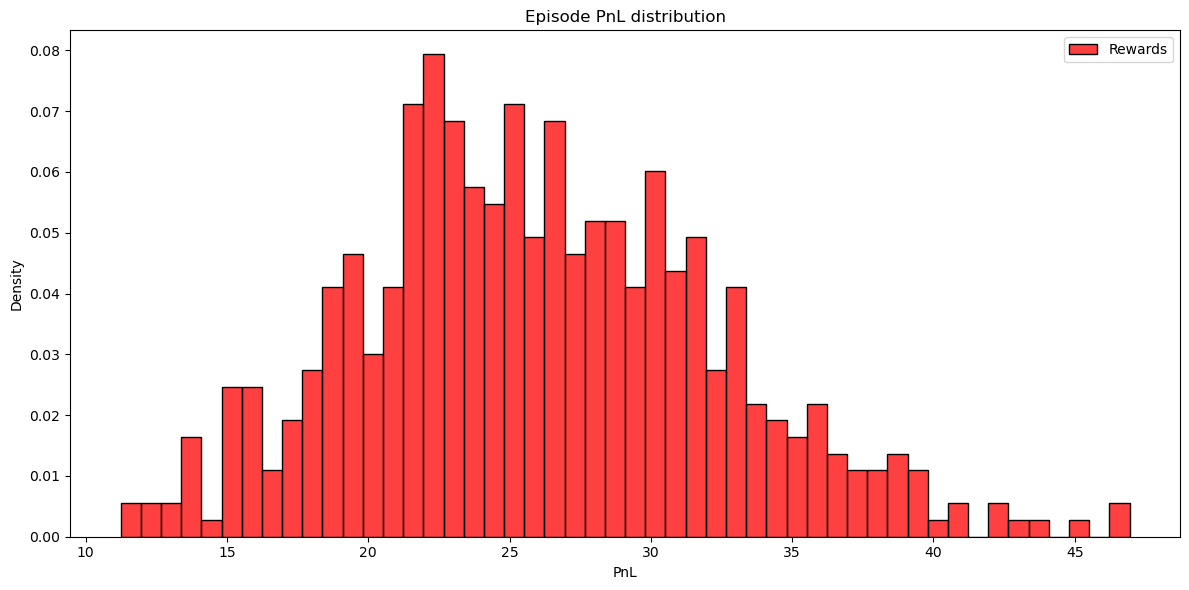

In [13]:
SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 100.0, 2.0, 140.0, 1.5, 1
dt = T / M
mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)

# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent_inf = AvellanedaStoikovAgent(env, gamma=0.8, mode="infinite", q_max=5)
plot_trajectory(env, agent_inf, show_reservation=False)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=512, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
agent_inf = AvellanedaStoikovAgent(env_vec, gamma=0.8, mode="infinite", q_max=5)
results, fig, totals = generate_results_table_and_hist(env_vec, agent_inf)
print(results)

Hawkes distribution

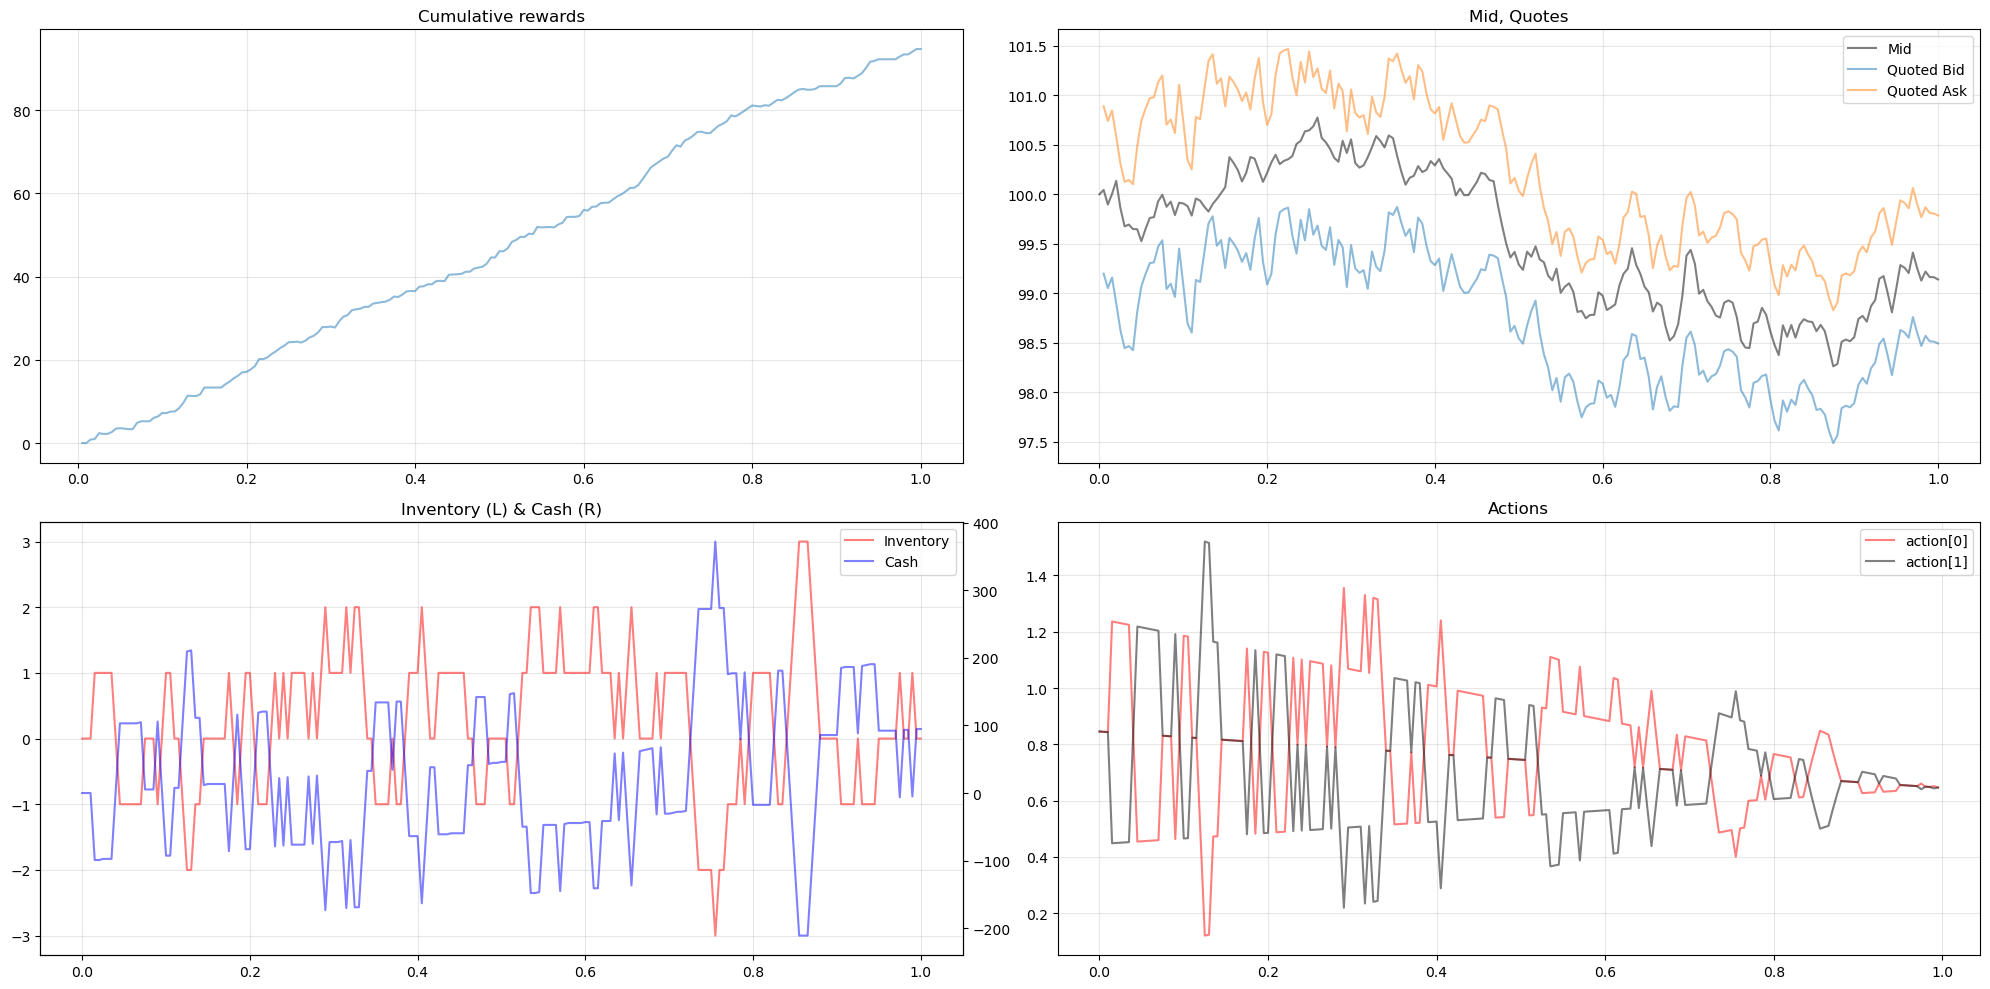

          Mean spread   Mean PnL  Std PnL Mean terminal inventory  \
Inventory    1.491867  92.886421  7.63121               -0.130859   

          Std terminal inventory  
Inventory                2.97917  


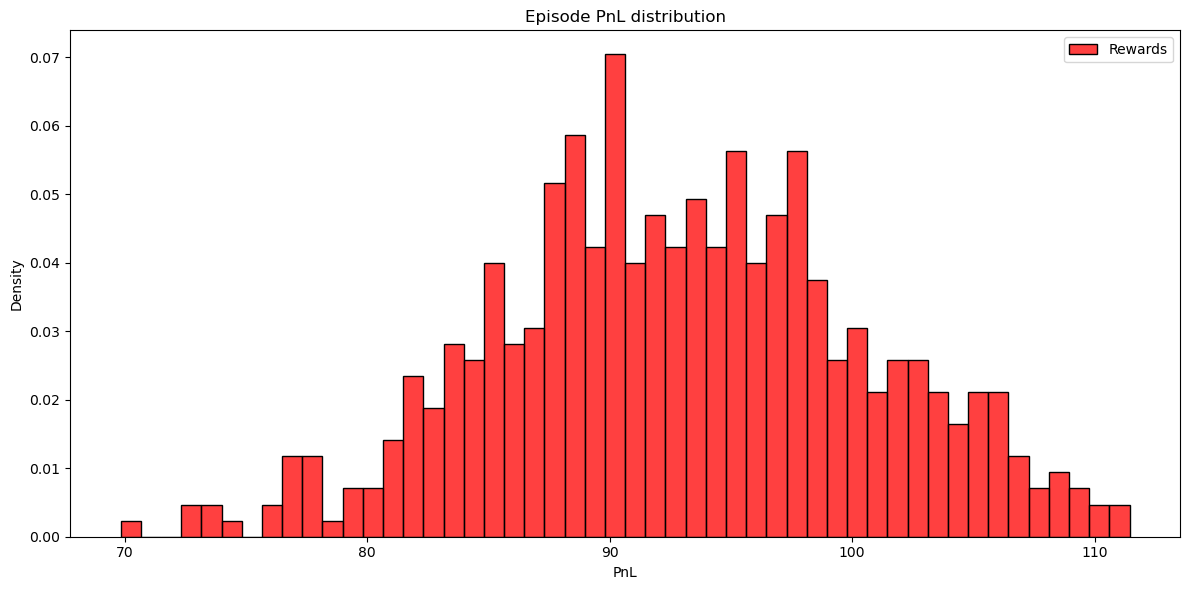

In [21]:
SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 100.0, 2.0, 140.0, 1.5, 1
dt = T / M
mu, kappa, jump = hawkes_params(dt=dt, p_target=0.30, eta=0.85, memory_steps=10)

mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = HawkesArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED, kappa=kappa, jump=jump)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)

# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = AvellanedaStoikovAgent(env, gamma=0.1)
plot_trajectory(env, agent, show_reservation=False)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = HawkesArrivals(A, A, num_traj=N, dt=dt, T=T, kappa=kappa, jump=jump, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
agent = AvellanedaStoikovAgent(env_vec, gamma=0.1)
results, fig, totals = generate_results_table_and_hist(env_vec, agent)
print(results)

GLFT

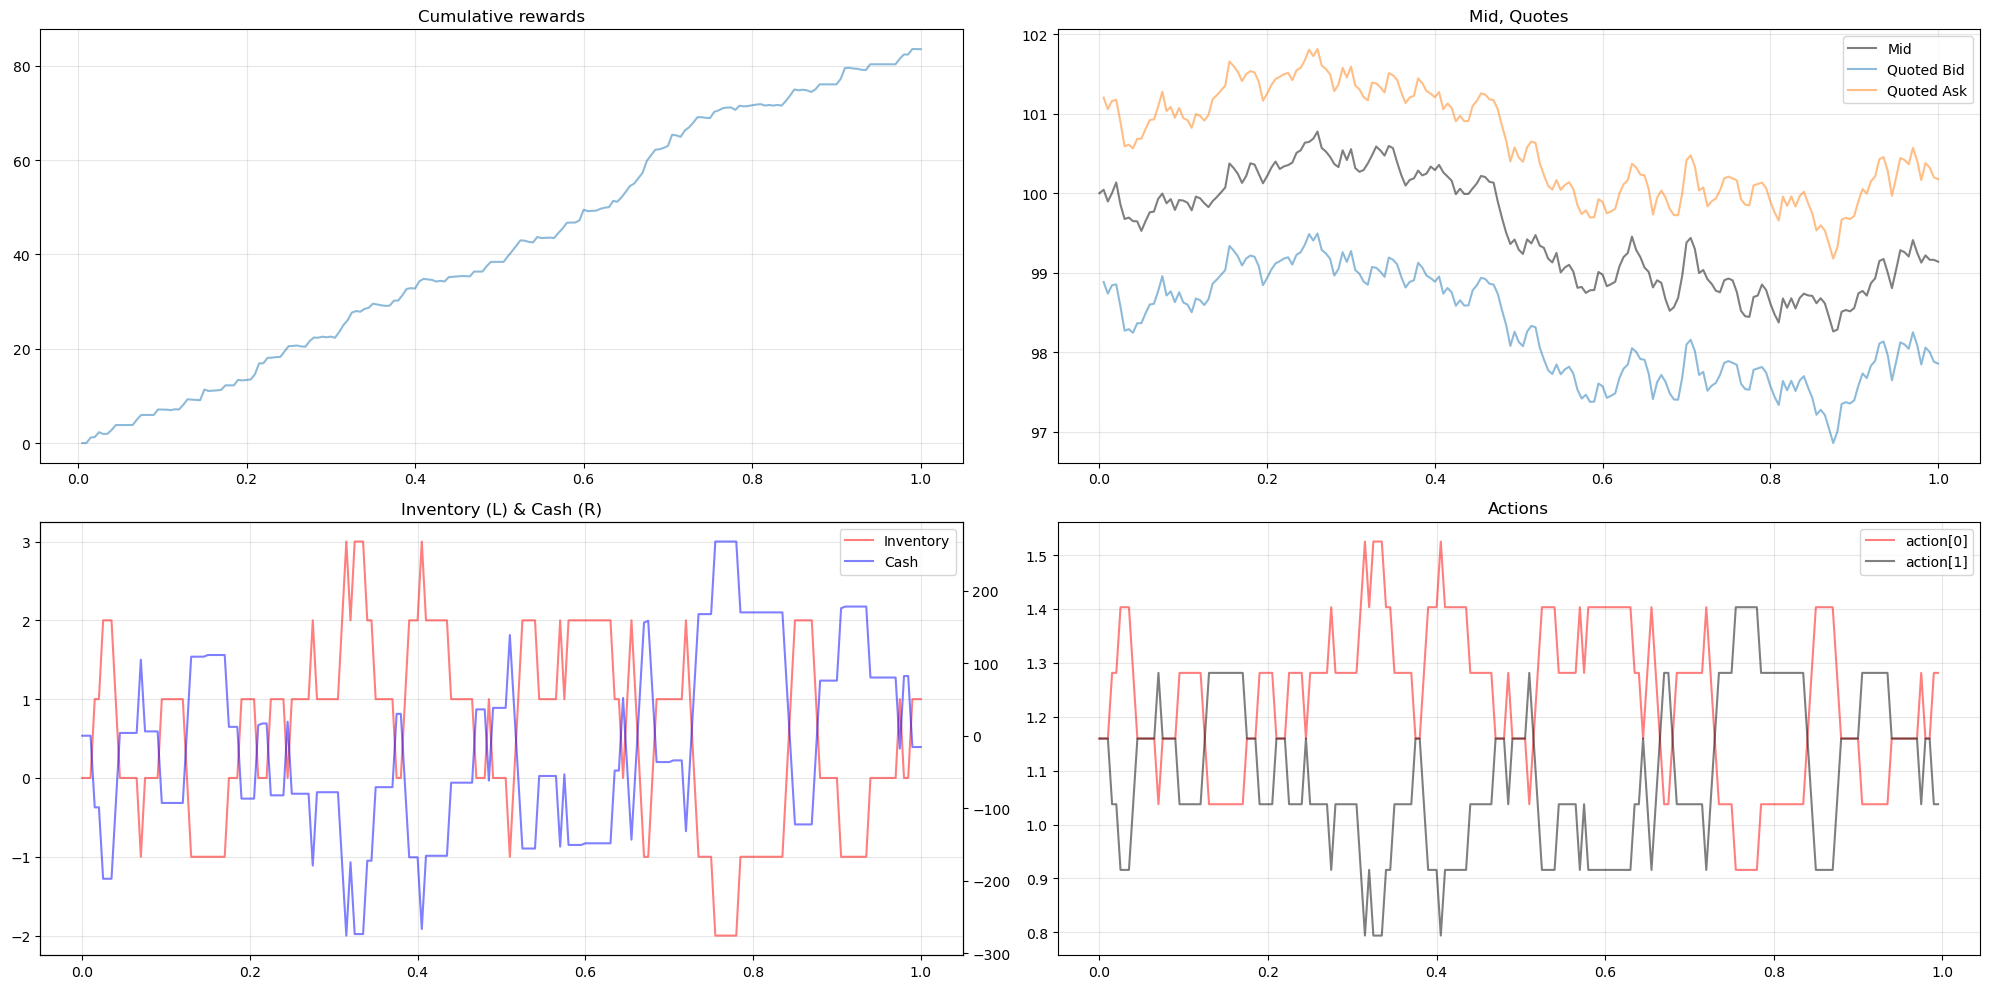

          Mean spread   Mean PnL   Std PnL Mean terminal inventory  \
Inventory    2.319069  81.018768  9.157394               -0.011719   

          Std terminal inventory  
Inventory               1.490811  


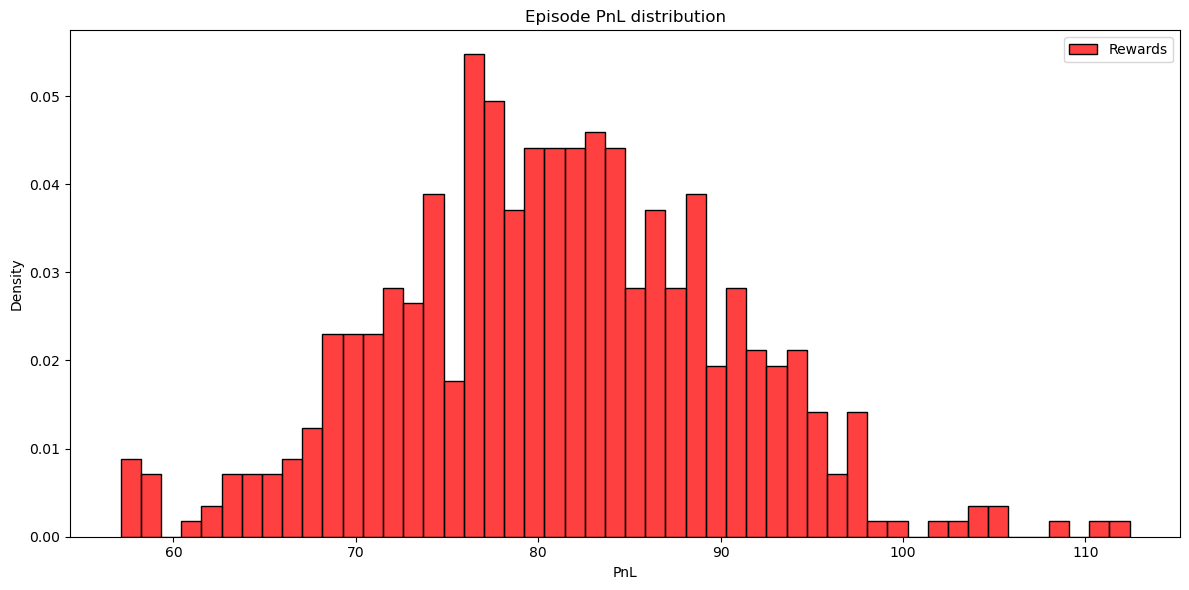

In [ ]:
SEED, T, M, s0, sigma, A, k_fill, N, k = 42, 1.0, 200, 100.0, 2.0, 140.0, 1.5, 1, 0.5
dt = T / M
mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
    
# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = GLFTAgent(env, gamma=0.1, A=A, k=k, xi=1.0, tick=1.0)
plot_trajectory(env, agent, show_reservation=False)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=512, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
GLFT_agent = GLFTAgent(env, gamma=0.1, A=A, k=k, xi=1.0, tick=1.0)
results, fig, totals = generate_results_table_and_hist(env_vec, GLFT_agent)
print(results)

Plotting difference between Poisson distribution and Hawkes distribution

In [ ]:
compare_poisson_vs_hawkes(dt=0.01, steps=200, seed=42,
                          lam_buy=30, lam_sell=30,
                          mu=10, kappa=60, jump=40)

In [ ]:
# auto-import path or pass your classes explicitly
from stochastic_proc.arrivals import PoissonArrivals, HawkesArrivals

compare_poisson_vs_hawkes(
    dt=0.01, steps=200, seed=42,
    lam_buy=30, lam_sell=30,
    mu=10, kappa=60, jump=40,
    poisson_cls=PoissonArrivals,
    hawkes_cls=HawkesArrivals,
)


In [ ]:
import inspect
from stochastic_proc.arrivals import PoissonArrivals, HawkesArrivals
print("PoissonArrivals:", inspect.signature(PoissonArrivals.__init__))
print("HawkesArrivals :", inspect.signature(HawkesArrivals.__init__))
